<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%BE%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B0_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B0_%D0%BE%D1%82%D0%B1%D0%BE%D1%80%D0%BE%D1%87%D0%BD%D0%BE%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

     |████████████████████████████████| 2.7MB 12.7MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533291 sha256=5a4c6003b11aaec01f4fdc5343871b45a5a876a03c31e8956e93b312166b9667
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=4056ba626437ee60d3174eb80d49c3c01af26e6a93d426a5d008c79558b22339
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-p1nj_0g6
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-p1nj_0g6
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=57e2e851a533847b17422a28b71c4afcbef86274d50d0ac7c22c7c00170d9324
  Stored in directory: /tmp/pip-ephem-wheel-cache-hvj06htu/wheels/9c/7a/cc/d1ffa9ccaa42

In [ ]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_evs_24.10.2020.pkl'

# Загрузка истории

In [ ]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.715343,7.238358
2010-01-05,6.616219,5.005957,10.770829,7.717158
2010-01-06,6.510980,4.798555,10.715343,8.005848
2010-01-07,6.498945,4.939965,11.270185,8.210042
2010-01-08,6.542150,4.845690,11.512927,8.231167
...,...,...,...,...
2020-10-19,115.980003,12.560000,7.290000,7.590000
2020-10-20,117.510002,12.800000,7.340000,7.740000
2020-10-21,116.870003,12.750000,7.320000,7.850000


# Алгоритм распределения

In [ ]:
def predWeights(dData,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100):

    n = dData.shape[1]
    
    X = pd.concat([dData.shift(lag+n) for n in range(1,lookback+1)],axis=1)
    y = dData
    xy = pd.concat([y[-learnLen:],X[-learnLen:]],axis=1).dropna()
    y = xy.iloc[:,:n]
    X = xy.iloc[:,n:]
    
    def loss_function(y_true, y_pred):
        return -tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dense(n+1,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=loss_function)
    #help(model.fit)
    learn_res = model.fit(X, y, epochs=1000,validation_split=0.2,verbose=False,use_multiprocessing=True,callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([dData.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(X)[-1,:-1]

    return weights

dData = data.to_returns()
#t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
t=1000

for n in range(10):
    weights = predWeights(dData[:t])
    print(weights,1-sum(weights))


[0.21780421 0.19153066 0.01557901 0.5358013 ] 0.03928482811897993
[0.24863128 0.16777919 0.17085554 0.3081728 ] 0.10456119477748871
[0.1388919  0.22911958 0.1938144  0.1838486 ] 0.2543255090713501
[0.08605321 0.23619863 0.18121168 0.33604664] 0.16048983484506607
[0.11011161 0.11265313 0.2379825  0.21918495] 0.3200678154826164
[0.07718012 0.13351698 0.1771465  0.41352284] 0.1986335590481758
[0.29278883 0.22900066 0.22154418 0.08835361] 0.16831272095441818
[0.0856429  0.2158325  0.1967625  0.31246206] 0.189300037920475
[0.25916195 0.45240206 0.14033814 0.08516457] 0.0629332885146141
[0.08038944 0.12154745 0.2640408  0.3757997 ] 0.15822263062000275


In [ ]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        dData = target.universe[selected].to_returns()
        
        weights = predWeights(dData,
                              lookback=self.lookback,
                              lag=self.lag,
                              learnLen=self.learnLen,
                              reg=np.power(10,self.reg),
                              min_delta=np.power(10,self.min_delta),
                              lr=np.power(10,self.lr),
                              hl=self.hl)

        target.temp['weights'] = pd.Series({dData.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [ ]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    # print('t=',t)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl)
    # print(weights)

    d = dData[t:(t+lag)]                # данные
    
    p = sum(d.mean().values*weights)    # на прогнозе среднее
    m = d.values.mean()                 # на курсах среднее
    v = abs(d.values).mean()            # на модулях изменений среднее
    
    # raise Exception()

    return (p-m)/v

## Создание модели

In [ ]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,200),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,500),
                      lag=range(1,200),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  6499 {'quality': 0.1443983698001719, 'lookback': 169, 'learnLen': 221, 'reg': -4.310000000000057, 'min_delta': -4.500000000000053, 'lr': -2.070000000000105, 'hl': 357, 'lag': 87}
finish -  6509 {'quality': -0.05215244145446921, 'lookback': 97, 'learnLen': 202, 'reg': -3.580000000000073, 'min_delta': -3.0300000000000846, 'lr': -2.8900000000000876, 'hl': 373, 'lag': 60}
finish -  6519 {'quality': -0.10811450362813278, 'lookback': 153, 'learnLen': 198, 'reg': -3.7000000000000703, 'min_delta': -4.250000000000059, 'lr': -3.72000000000007, 'hl': 410, 'lag': 77}
finish -  6529 {'quality': 0.31271572906794987, 'lookback': 151, 'learnLen': 198, 'reg': -3.6500000000000714, 'min_delta': -4.0200000000000635, 'lr': -2.7600000000000904, 'hl': 383, 'lag': 51}
finish -  6539 {'quality': 0.04646479096950674, 'lookback': 152, 'learnLen': 240, 'reg': -4.090000000000062, 'min_delta': -3.1800000000000814, 'lr': -2.6500000000000927, 'hl': 433, 'lag': 77}
finish -  6549 {'quality': 0.00692638547125

KeyboardInterrupt: ignored

## Графики

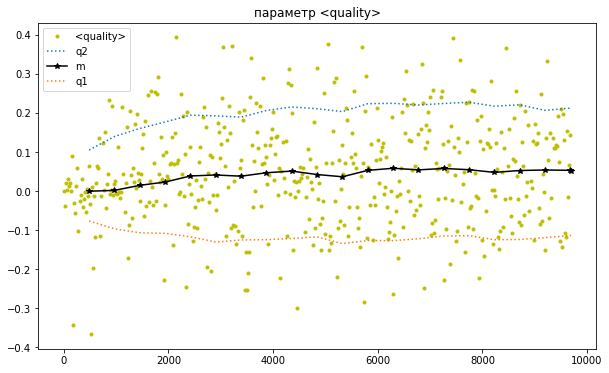

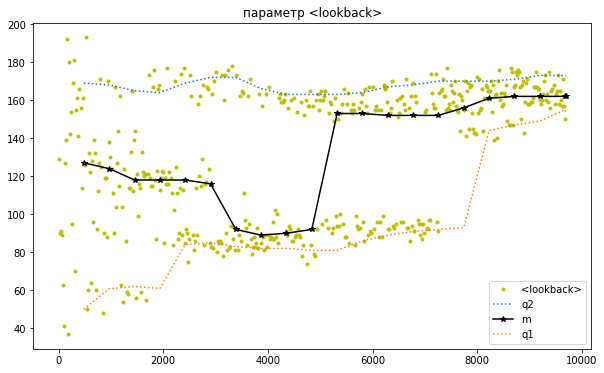

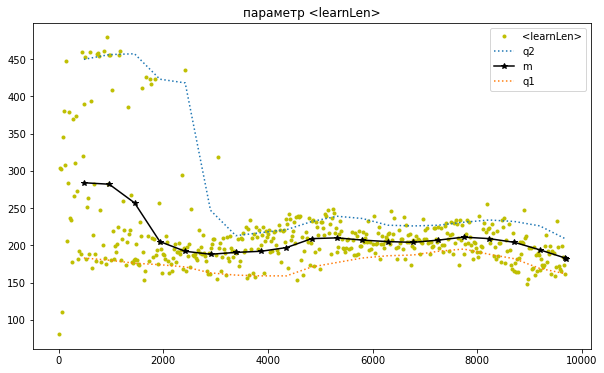

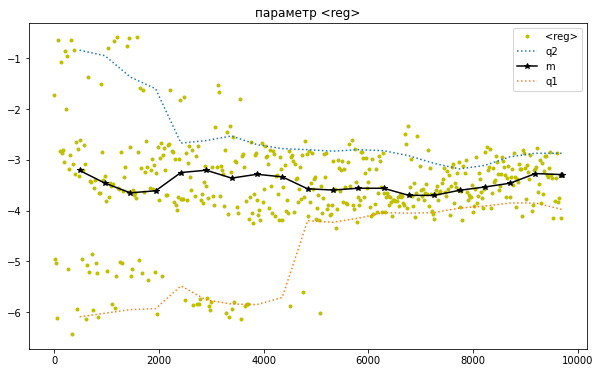

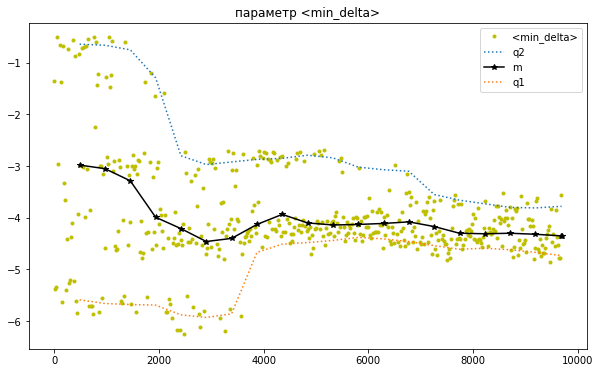

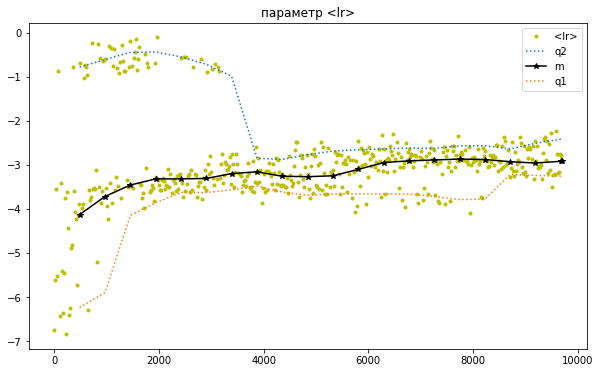

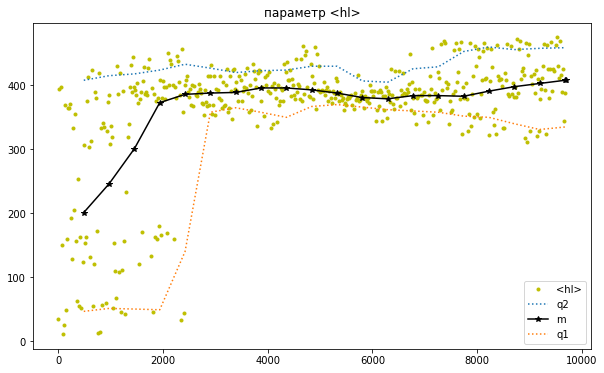

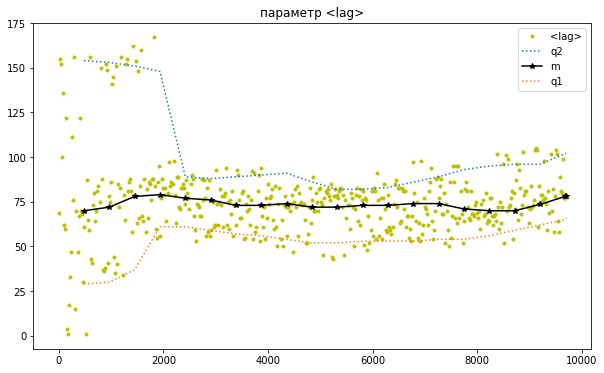

In [ ]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag'))


## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'hl': 413,
 'lag': 84,
 'learnLen': 180,
 'lookback': 163,
 'lr': -2.8500000000000885,
 'min_delta': -4.310000000000057,
 'reg': -3.5000000000000746}

# Прогон лучшей

In [ ]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:01равновесный
0% [############################# ] 100% | ETA: 00:00:00

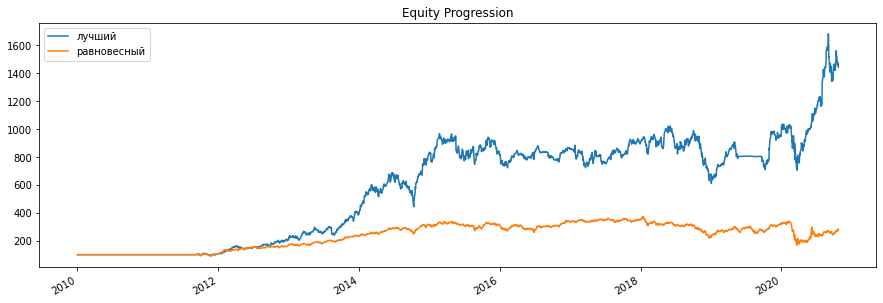

In [ ]:
res_best.plot()

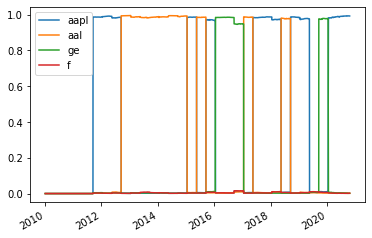

In [ ]:
res_best.get_security_weights().plot()

Text(0.5, 1.0, 'нераспределенные деньги (доля)')

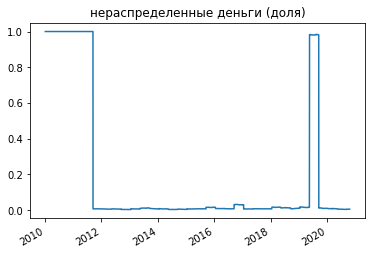

In [ ]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:-1].sum(axis=1)
w['деньги'].plot()
plt.title('нераспределенные деньги (доля)')

In [ ]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-10-23  2020-10-23
Risk-free rate       0.00%       0.00%

Total Return         1346.07%    178.63%
Daily Sharpe         0.98        0.52
Daily Sortino        1.63        0.82
CAGR                 28.05%      9.95%
Max Drawdown         -40.16%     -55.32%
Calmar Ratio         0.70        0.18

MTD                  -0.60%      11.12%
3m                   23.97%      14.52%
6m                   67.51%      46.02%
YTD                  51.60%      -12.48%
1Y                   84.79%      -2.34%
3Y (ann.)            20.66%      -7.34%
5Y (ann.)            9.54%       -3.30%
10Y (ann.)           30.64%      10.80%
Since Incep. (ann.)  28.05%      9.95%

Daily Sharpe         0.98        0.52
Daily Sortino        1.63        0.82
Daily Mean (ann.)    29.11%      12.33%
Daily Vol (ann.)     29.56%      23.87%
Daily Skew           0.10  